# The metrics of comparing fields in `Exponax`

There are four major classes of metrics:

1. Spatial-based (that work in physical space)
2. Fourier-based (that work in the coefficient space)
3. Correlation-based
4. Derivative-based (which sugarcoat the functionalities to Fourier-based
   approaches to achieve Sobolev-like norms)

Class 1., 2., and 4. can be further divided into:
1. Absolute metrics (i.e., related to the MAE)
2. Absolute squared metrics (i.e., related to the MSE)
3. Rooted metrics (i.e., related to the RMSE)

Then for each of the three, there is both the absolute version and a
relative/normalized version. For all spatial-based metrics, MAE, MSE, and RMSE
also come with a symmetric version.

All metrics computation work on single state arrays, i.e., arrays with a leading channel axis and one, two, or three subsequent spatial axes. **The arrays shall not have leading batch axes.** To work with batched arrays use `jax.vmap` and then reduce, e.g., by `jnp.mean`. Alternatively, use the convinience wrapper [`exponax.metrics.mean_metric`][].

All metrics **sum over the channel axis**.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [2]:
import exponax as ex

## Setup: Reference and Predicted States

Let's create two 1D fields using `DiffusedNoise`. We use the same random key
so the signals share large-scale structure, but different `intensity` values
produce different levels of smoothing.

In [3]:
NUM_POINTS = 100

u_ref = ex.ic.DiffusedNoise(1, intensity=0.001)(NUM_POINTS, key=jax.random.PRNGKey(0))
u_pred = ex.ic.DiffusedNoise(1, intensity=0.0005)(NUM_POINTS, key=jax.random.PRNGKey(0))

print("u_ref shape:", u_ref.shape)
print("u_pred shape:", u_pred.shape)

u_ref shape: (1, 100)
u_pred shape: (1, 100)


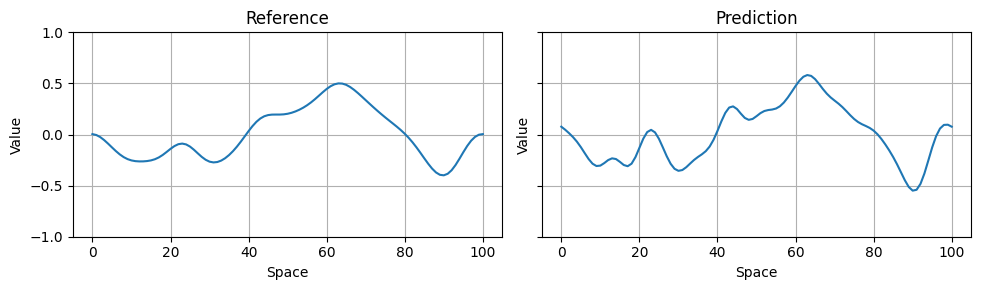

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ex.viz.plot_state_1d(u_ref, ax=axes[0])
axes[0].set_title("Reference")
ex.viz.plot_state_1d(u_pred, ax=axes[1])
axes[1].set_title("Prediction")
plt.tight_layout()
plt.show()

## The Standard Candidates: MAE, MSE, RMSE

### Absolute Metrics

The three workhorses of error measurement:

- **MAE** (Mean Absolute Error) — related to the L1 norm of the error
- **MSE** (Mean Squared Error) — related to the squared L2 norm of the error
- **RMSE** (Root Mean Squared Error) — related to the L2 norm of the error

In [5]:
mae = ex.metrics.MAE(u_pred, u_ref)
mse = ex.metrics.MSE(u_pred, u_ref)
rmse = ex.metrics.RMSE(u_pred, u_ref)

print(f"MAE  = {mae:.6f}")
print(f"MSE  = {mse:.6f}")
print(f"RMSE = {rmse:.6f}")

MAE  = 0.046460
MSE  = 0.003603
RMSE = 0.060028


As expected, `RMSE = sqrt(MSE)`:

In [6]:
print(f"sqrt(MSE) = {jnp.sqrt(mse):.6f}")
print(f"RMSE      = {rmse:.6f}")

sqrt(MSE) = 0.060028
RMSE      = 0.060028


If no reference is provided, the metric computes the norm of the state itself
(i.e., the error against zero):

In [7]:
print(f"RMSE(u_ref, ref=None) = {ex.metrics.RMSE(u_ref):.6f}  (norm of u_ref)")
print(f"RMSE(u_ref, ref=0)    = {ex.metrics.RMSE(u_ref, jnp.zeros_like(u_ref)):.6f}")

RMSE(u_ref, ref=None) = 0.251945  (norm of u_ref)
RMSE(u_ref, ref=0)    = 0.251945


### Normalized/Relative Metrics

The normalized variants divide the absolute metric by the norm of the reference.
This makes them **scale-invariant**: the error is expressed relative to the
magnitude of the reference signal.

In [8]:
nmae = ex.metrics.nMAE(u_pred, u_ref)
nmse = ex.metrics.nMSE(u_pred, u_ref)
nrmse = ex.metrics.nRMSE(u_pred, u_ref)

print(f"nMAE  = {nmae:.6f}")
print(f"nMSE  = {nmse:.6f}")
print(f"nRMSE = {nrmse:.6f}")

nMAE  = 0.213336
nMSE  = 0.056767
nRMSE = 0.238259


**Scale invariance:** multiplying both signals by the same constant leaves `nRMSE` unchanged:

In [9]:
scale = 10.0
nrmse_original = ex.metrics.nRMSE(u_pred, u_ref)
nrmse_scaled = ex.metrics.nRMSE(scale * u_pred, scale * u_ref)

print(f"nRMSE (original) = {nrmse_original:.6f}")
print(f"nRMSE (x{scale:.0f})     = {nrmse_scaled:.6f}")

nRMSE (original) = 0.238259
nRMSE (x10)     = 0.238259


There are also **symmetric** variants (`sMAE`, `sMSE`, `sRMSE`) that normalize
by the sum of the norms of both signals. These are bounded between 0 and the
number of channels C:

In [10]:
print(f"sRMSE = {ex.metrics.sRMSE(u_pred, u_ref):.6f}  (bounded in [0, C])")

sRMSE = 0.225342  (bounded in [0, C])


### Why it needs the domain size?

All metrics approximate continuous integrals via the trapezoidal rule:

$$\text{MSE} \approx \frac{1}{L^D} \int_\Omega |u_{\text{pred}} - u_{\text{ref}}|^2 \, dx \approx \frac{1}{N^D} \sum_{i} |u_{\text{pred},i} - u_{\text{ref},i}|^2$$

Because of the $(L/N)^D$ grid spacing factor, changing the `domain_extent`
changes the absolute metric values.

In [11]:
for L in [1.0, 2.0, 5.0]:
    mse_L = ex.metrics.MSE(u_pred, u_ref, domain_extent=L)
    nrmse_L = ex.metrics.nRMSE(u_pred, u_ref, domain_extent=L)
    print(f"L={L:.1f}:  MSE={mse_L:.6f}   nRMSE={nrmse_L:.6f}")

L=1.0:  MSE=0.003603   nRMSE=0.238259
L=2.0:  MSE=0.007207   nRMSE=0.238259
L=5.0:  MSE=0.018017   nRMSE=0.238259


Notice that `MSE` changes with domain extent, but `nRMSE` stays constant because
the domain-extent factor cancels in the ratio.

**Practical advice:** When using metrics as optimization objectives (e.g., for
training neural emulators), the domain extent is just a constant factor and does
not affect the optimizer. But when comparing metrics across different setups,
make sure `domain_extent` is set correctly.

## Correlation

Correlation measures the **shape similarity** between two fields via a
normalized dot product. It ranges from -1 (anti-correlated) to +1 (identical
shape). Crucially, it does *not* capture amplitude differences.

In [12]:
corr = ex.metrics.correlation(u_pred, u_ref)
print(f"correlation(u_pred, u_ref) = {corr:.6f}")

correlation(u_pred, u_ref) = 0.980431


In [13]:
# Identical fields -> correlation = 1.0
print(f"correlation(u_ref, u_ref)  = {ex.metrics.correlation(u_ref, u_ref):.6f}")

# Amplitude scaling does not change correlation
print(
    f"correlation(10*u_pred, u_ref) = {ex.metrics.correlation(10 * u_pred, u_ref):.6f}"
)

correlation(u_ref, u_ref)  = 1.000000
correlation(10*u_pred, u_ref) = 0.980431


In [14]:
# Two uncorrelated random fields -> correlation ~ 0
u_random = ex.ic.DiffusedNoise(1, intensity=0.001)(
    NUM_POINTS, key=jax.random.PRNGKey(42)
)
print(f"correlation(u_ref, u_random) = {ex.metrics.correlation(u_ref, u_random):.6f}")

correlation(u_ref, u_random) = 0.633428


## Fourier-based Metrics

### Wait? Isn't that my MSE? A quick intro to Parseval's theorem

**Parseval's theorem** tells us that the L2 norm in physical space equals the
L2 norm in Fourier space. So `fourier_MSE` should numerically agree with `MSE`:

In [15]:
mse_spatial = ex.metrics.MSE(u_pred, u_ref)
mse_fourier = ex.metrics.fourier_MSE(u_pred, u_ref)

print(f"MSE (spatial)  = {mse_spatial:.8f}")
print(f"fourier_MSE    = {mse_fourier:.8f}")
print(f"Difference     = {abs(mse_spatial - mse_fourier):.2e}")

MSE (spatial)  = 0.00360337
fourier_MSE    = 0.00360337
Difference     = 0.00e+00


In [16]:
# Same holds for RMSE and nRMSE
print(f"RMSE         = {ex.metrics.RMSE(u_pred, u_ref):.8f}")
print(f"fourier_RMSE = {ex.metrics.fourier_RMSE(u_pred, u_ref):.8f}")
print()
print(f"nRMSE         = {ex.metrics.nRMSE(u_pred, u_ref):.8f}")
print(f"fourier_nRMSE = {ex.metrics.fourier_nRMSE(u_pred, u_ref):.8f}")

RMSE         = 0.06002804
fourier_RMSE = 0.06002804

nRMSE         = 0.23825857
fourier_nRMSE = 0.23825857


### Filtering and Scale-Specific Metrics

The Fourier-based metrics accept `low` and `high` parameters to restrict the
error computation to specific frequency (wavenumber) ranges. This lets you
measure the error at different spatial scales.

Let's demonstrate: we add high-frequency noise to a signal and show that the
low-frequency error remains small while the full-spectrum error is large.

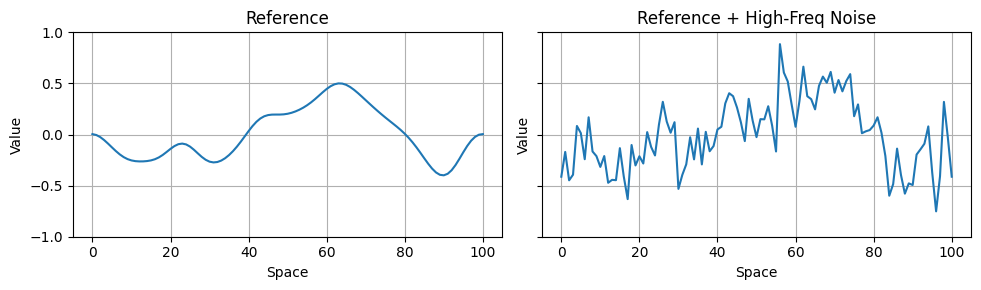

In [17]:
# Add high-frequency noise
noise = 0.3 * ex.ic.DiffusedNoise(1, intensity=0.00001)(
    NUM_POINTS, key=jax.random.PRNGKey(1)
)
u_noisy = u_ref + noise

fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ex.viz.plot_state_1d(u_ref, ax=axes[0])
axes[0].set_title("Reference")
ex.viz.plot_state_1d(u_noisy, ax=axes[1])
axes[1].set_title("Reference + High-Freq Noise")
plt.tight_layout()
plt.show()

In [18]:
print("Full spectrum:")
print(f"  fourier_nRMSE = {ex.metrics.fourier_nRMSE(u_noisy, u_ref):.6f}")
print()
print("Low frequencies only (wavenumbers 0..5):")
print(f"  fourier_nRMSE = {ex.metrics.fourier_nRMSE(u_noisy, u_ref, high=5):.6f}")
print()
print("High frequencies only (wavenumbers 5..):")
print(f"  fourier_nRMSE = {ex.metrics.fourier_nRMSE(u_noisy, u_ref, low=5):.6f}")

Full spectrum:
  fourier_nRMSE = 0.878996

Low frequencies only (wavenumbers 0..5):
  fourier_nRMSE = 0.317851

High frequencies only (wavenumbers 5..):
  fourier_nRMSE = 3.465855


This also works in higher dimensions. Here is a 2D example:

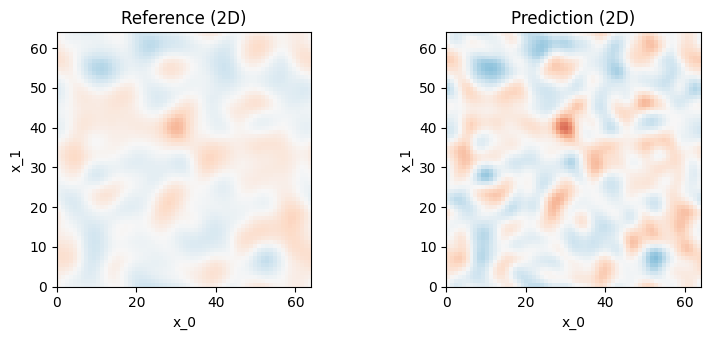

In [19]:
u_ref_2d = ex.ic.DiffusedNoise(2, intensity=0.001)(64, key=jax.random.PRNGKey(0))
u_pred_2d = ex.ic.DiffusedNoise(2, intensity=0.0005)(64, key=jax.random.PRNGKey(0))

fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))
ex.viz.plot_state_2d(u_ref_2d, ax=axes[0])
axes[0].set_title("Reference (2D)")
ex.viz.plot_state_2d(u_pred_2d, ax=axes[1])
axes[1].set_title("Prediction (2D)")
plt.tight_layout()
plt.show()

In [20]:
print("2D fourier_nRMSE (full spectrum):")
print(f"  {ex.metrics.fourier_nRMSE(u_pred_2d, u_ref_2d):.6f}")
print("2D fourier_nRMSE (low freq, high=5):")
print(f"  {ex.metrics.fourier_nRMSE(u_pred_2d, u_ref_2d, high=5):.6f}")
print("2D fourier_nRMSE (high freq, low=5):")
print(f"  {ex.metrics.fourier_nRMSE(u_pred_2d, u_ref_2d, low=5):.6f}")

2D fourier_nRMSE (full spectrum):
  0.623704
2D fourier_nRMSE (low freq, high=5):
  0.394104
2D fourier_nRMSE (high freq, low=5):
  1.405712


### Metrics with derivatives

The Fourier-based metrics support a `derivative_order` parameter. Setting
`derivative_order=1` computes the error of the first derivative (done spectrally
by multiplying with `ik` in Fourier space — no finite differences needed).

In [21]:
rmse_0 = ex.metrics.fourier_RMSE(u_pred, u_ref)
rmse_1 = ex.metrics.fourier_RMSE(u_pred, u_ref, derivative_order=1)
rmse_2 = ex.metrics.fourier_RMSE(u_pred, u_ref, derivative_order=2)

print(f"fourier_RMSE (0th derivative) = {rmse_0:.6f}")
print(f"fourier_RMSE (1st derivative) = {rmse_1:.6f}")
print(f"fourier_RMSE (2nd derivative) = {rmse_2:.6f}")

fourier_RMSE (0th derivative) = 0.060028
fourier_RMSE (1st derivative) = 2.694910
fourier_RMSE (2nd derivative) = 151.683289


Higher derivative orders amplify high-frequency errors, making these metrics
sensitive to fine-scale discrepancies.

## Sobolev-like Metrics

### Wait? Who is Sobolev?

The $H^1$ (Sobolev) norm combines the $L^2$ norm of the function itself with
the $L^2$ norm of its gradient:

$$\|u\|_{H^1}^2 = \|u\|_{L^2}^2 + \|\nabla u\|_{L^2}^2$$

This means $H^1$ metrics penalize both **value errors** and
**derivative/smoothness errors**. They are especially useful for detecting
predictions that have the right large-scale structure but wrong fine-scale
details.

In [22]:
u_strongly_diffused = ex.ic.DiffusedNoise(1, intensity=0.001)(
    100, key=jax.random.PRNGKey(0)
)
u_less_diffused = ex.ic.DiffusedNoise(1, intensity=0.0003)(
    100, key=jax.random.PRNGKey(0)
)

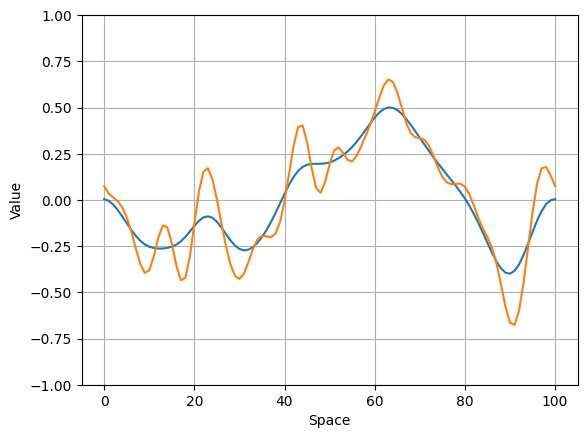

In [23]:
ex.viz.plot_state_1d(jnp.concatenate([u_strongly_diffused, u_less_diffused]))

In [24]:
nrmse_val = ex.metrics.nRMSE(u_strongly_diffused, u_less_diffused)
h1_nrmse_val = ex.metrics.H1_nRMSE(u_strongly_diffused, u_less_diffused)

print(f"nRMSE    = {nrmse_val:.6f}")
print(f"H1_nRMSE = {h1_nrmse_val:.6f}")

nRMSE    = 0.376697
H1_nRMSE = 1.159826


The `H1_nRMSE` is significantly larger than `nRMSE` because the two fields
differ substantially in their gradient (smoothness) content.

### Application: Detecting Blurry Predictions of Neural Emulators

A common failure mode of neural PDE emulators is producing **blurry**
predictions: the large-scale structure is correct, but fine details are smeared
out. Standard `nRMSE` may look acceptable, but `H1_nRMSE` reveals the
smoothness mismatch.

Let's simulate this scenario with the 1D Burgers equation.

In [25]:
# Run a Burgers simulation to get a "ground truth" state
burgers = ex.stepper.Burgers(
    num_spatial_dims=1,
    domain_extent=1.0,
    num_points=100,
    dt=0.1,
    diffusivity=0.01,
)

u0 = ex.ic.DiffusedNoise(1, intensity=0.0005, max_one=True)(
    100, key=jax.random.PRNGKey(0)
)
# Step forward a few times to develop sharp gradients
trj = ex.rollout(burgers, 5, include_init=True)(u0)
u_truth = trj[-1]  # ground truth at t=0.5

print("u_truth shape:", u_truth.shape)

u_truth shape: (1, 100)


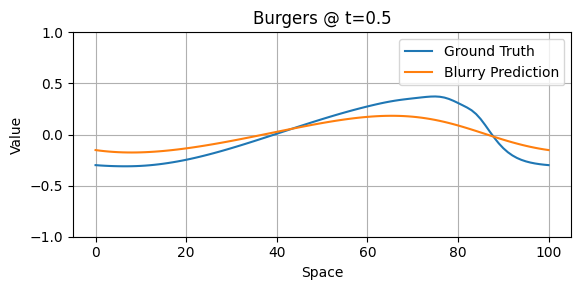

In [26]:
# Create a "blurry" prediction by running with much higher diffusivity
burgers_blurry = ex.stepper.Burgers(
    num_spatial_dims=1,
    domain_extent=1.0,
    num_points=100,
    dt=0.1,
    diffusivity=0.05,  # 5x more diffusion
)
trj_blurry = ex.rollout(burgers_blurry, 5, include_init=True)(u0)
u_blurry = trj_blurry[-1]

fig, ax = plt.subplots(figsize=(6, 3))
ex.viz.plot_state_1d(
    jnp.concatenate([u_truth, u_blurry]),
    ax=ax,
    labels=["Ground Truth", "Blurry Prediction"],
)
ax.legend()
ax.set_title("Burgers @ t=0.5")
plt.tight_layout()
plt.show()

In [27]:
print(f"nRMSE    = {ex.metrics.nRMSE(u_blurry, u_truth):.6f}")
print(f"H1_nRMSE = {ex.metrics.H1_nRMSE(u_blurry, u_truth):.6f}")
print()
print("The H1 metric is more sensitive to the blurriness because it also")
print("penalizes the smoothed-out gradients.")

nRMSE    = 0.514229
H1_nRMSE = 1.173806

The H1 metric is more sensitive to the blurriness because it also
penalizes the smoothed-out gradients.


## Working with Batches

All metrics operate on single states (no batch axis). To compute metrics over a
batch, use `exponax.metrics.mean_metric` which vmaps and averages for you:

In [28]:
# Generate a small batch of initial conditions
keys = jax.random.split(jax.random.PRNGKey(0), 8)
ic_gen_ref = ex.ic.DiffusedNoise(1, intensity=0.001)
ic_gen_pred = ex.ic.DiffusedNoise(1, intensity=0.0005)

batch_ref = jax.vmap(lambda k: ic_gen_ref(NUM_POINTS, key=k))(keys)
batch_pred = jax.vmap(lambda k: ic_gen_pred(NUM_POINTS, key=k))(keys)

print(f"batch_ref shape:  {batch_ref.shape}")
print(f"batch_pred shape: {batch_pred.shape}")

batch_ref shape:  (8, 1, 100)
batch_pred shape: (8, 1, 100)


In [29]:
mean_nrmse = ex.metrics.mean_metric(ex.metrics.nRMSE, batch_pred, batch_ref)
mean_h1 = ex.metrics.mean_metric(ex.metrics.H1_nRMSE, batch_pred, batch_ref)

print(f"Mean nRMSE    over batch = {mean_nrmse:.6f}")
print(f"Mean H1_nRMSE over batch = {mean_h1:.6f}")

Mean nRMSE    over batch = 0.345164
Mean H1_nRMSE over batch = 1.209620
